In [1]:
import sys
import os
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
import numpy as np
from sklearn.datasets import make_blobs
import pandas as pd

np.random.seed(42)

In [3]:
X, y, centers = make_blobs(
    n_samples=10000,
    n_features=15,
    centers=15,
    cluster_std=7.6,
    return_centers=True,
    random_state=42
)

In [4]:
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

In [5]:
data = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(15)])
data['y'] = y

In [6]:
import seaborn as sns

<Axes: xlabel='x1', ylabel='x2'>

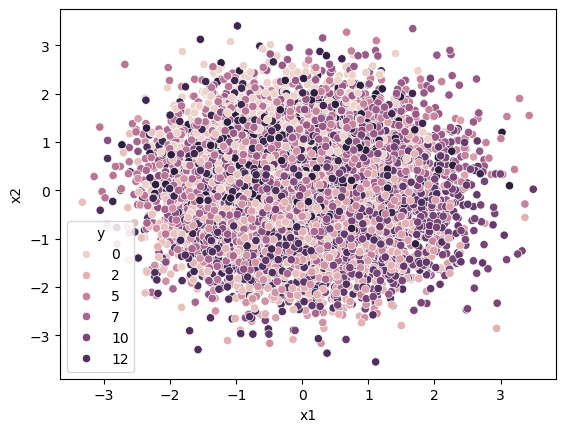

In [7]:
sns.scatterplot(x=data.x1, y=data.x2, hue=data.y)

In [8]:
from connector import spark_connector

In [9]:
from pyspark.sql import Window
from pyspark.sql import functions as F, types as T
import numpy as np
import pandas as pd

In [10]:
spark_connector?

Init signature:
spark_connector(
    exec_inst: int = 100,
    exec_cores: int = 5,
    aloc_max: int = 500,
    memory_exec: int = 25,
    name: object = 'utopialvo',
    rootdir: object = 'remote_dir_in_hdft',
    enable_graphframes: bool = False,
    enable_clickhouse: bool = False,
    enable_postgres: bool = False,
    dynamic_allocation: bool = False,
    intensive_mode: bool = False,
    marshal_mode: bool = True,
    yarn: bool = True,
) -> None
Docstring:     
Класс стандартного подключения к Spark

exec_inst - количество контейнеров
exec_cores - количество ядер в контейнере
aloc_max - максимальное количество ядер для dynamic_allocation (если он вкл)
memory_exec - количество памяти в контейнере
name - название подключения для упрощения логгирования подключений в кластере
rootdir - корневая папка в HDFS 
enable_graphframes - включить работу с graphframes
enable_clickhouse - включить работу с clickhouse
enable_postgres - включить работу с postgres
dynamic_allocation - включить д

In [11]:
con = spark_connector(exec_inst=2, exec_cores=8, memory_exec=15, enable_graphframes=True, marshal_mode=False, yarn = False)

In [12]:
con.spark

In [14]:
df = con.spark.createDataFrame(data)

In [15]:
from LSHP import LSHSampler

In [16]:
lsh_sampler = LSHSampler(
    input_cols=df.drop('y').columns,
    num_hashes=2,
    bin_widths=[0.5, 1.0, 2.0],
    random_proj=False,
    seed=42,
    output_prefix="lsh_buckets"
)

In [87]:
bucket_df = lsh_sampler.transform(df).withColumn(
    "bucket_2", F.concat_ws("|", F.col("lsh_buckets_2")))

/usr/local/spark/python/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/spark/python/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [88]:
print(f"\nBucket structure preview: {bucket_df.select('bucket_2').distinct().count()}")
print(f"\nBucket count: {bucket_df.select('bucket_2').count()}")


Bucket structure preview: 517

Bucket count: 10000


In [89]:
sampled = lsh_sampler.sample(df, n_samples=700, inverse_density=True)

In [91]:
print(f"Sampled count: {sampled.count()}, count bucket: {bucket_df.select('lsh_buckets_2').distinct().count()}")

Sampled count: 712, count bucket: 517


In [106]:
sampled = lsh_sampler.sample(df, n_samples=700, inverse_density=False)

/usr/local/spark/python/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/spark/python/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [107]:
print(f"Sampled count: {sampled.count()}, count bucket: {bucket_df.select('lsh_buckets_2').distinct().count()}")

Sampled count: 687, count bucket: 517


In [108]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [109]:
original_data = df.toPandas()[[f'x{i+1}' for i in range(15)] + ['y']]
sampled_data = sampled.toPandas()[[f'x{i+1}' for i in range(15)] + ['y']]

In [110]:
original_data.shape

(10000, 16)

In [111]:
sampled_data.shape

(687, 16)

In [112]:
from sklearn.metrics import adjusted_rand_score

In [113]:
# Кластеризация
def evaluate_clustering(data, true_centers):
    kmeans = KMeans(n_clusters=15, random_state=42).fit(data.drop('y', axis=1))
    error = adjusted_rand_score(kmeans.labels_, data.y)
    return error

In [114]:
original_error = evaluate_clustering(original_data, centers)
sampled_error = evaluate_clustering(sampled_data, centers)

print(f"Original data error: {original_error:.4f}")
print(f"Sampled data error: {sampled_error:.4f}")

Original data error: 0.6010
Sampled data error: 0.5110


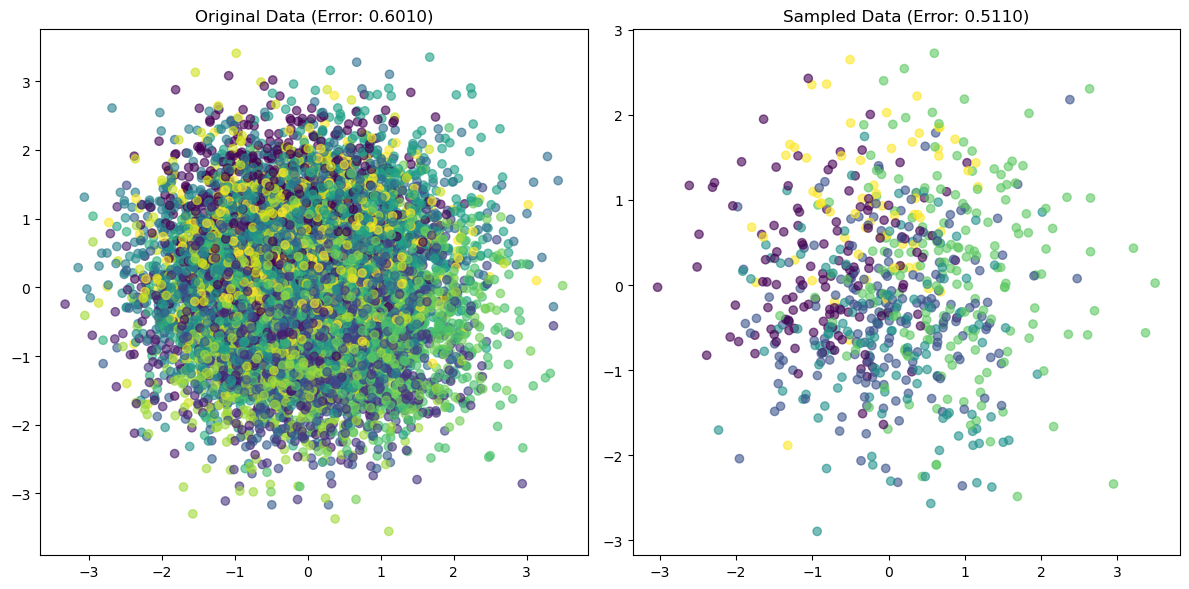

In [115]:
# 6. Визуализация
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(original_data['x1'], original_data['x2'], c=y, cmap='viridis', alpha=0.6)
plt.title(f"Original Data (Error: {original_error:.4f})")

plt.subplot(122)
sampled_y = KMeans(n_clusters=5, random_state=75).fit_predict(sampled_data.drop('y', axis=1))
plt.scatter(sampled_data['x1'], sampled_data['x2'], c=sampled_y, cmap='viridis', alpha=0.6)
plt.title(f"Sampled Data (Error: {sampled_error:.4f})")

plt.tight_layout()
plt.show()

In [116]:
kmeans2 = KMeans(n_clusters=15, random_state=42).fit(sampled_data.drop('y', axis=1))

error2 = adjusted_rand_score(kmeans2.predict(original_data.drop('y', axis=1)), original_data.y)

In [117]:
error2

0.5099259616922881

In [122]:
sampled_data2 = original_data.sample(n=687, random_state=42)

In [123]:
kmeans3 = KMeans(n_clusters=15, random_state=42).fit(sampled_data2.drop('y', axis=1))

error3 = adjusted_rand_score(kmeans3.predict(original_data.drop('y', axis=1)), original_data.y)

In [124]:
error3

0.4667923311420199

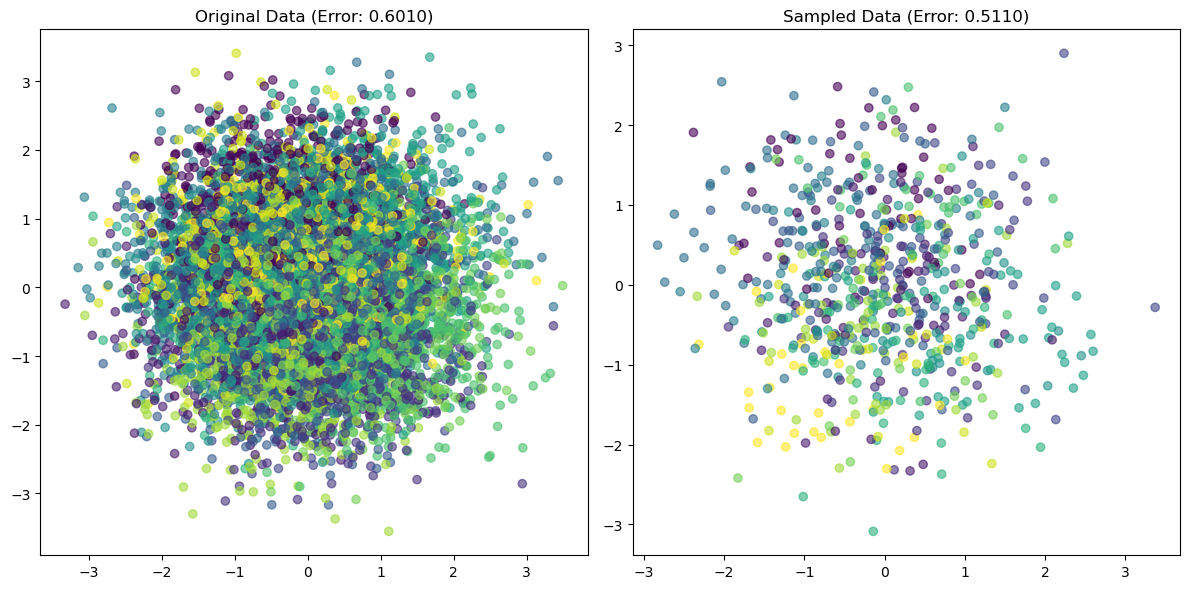

In [125]:
# 6. Визуализация
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(original_data['x1'], original_data['x2'], c=y, cmap='viridis', alpha=0.6)
plt.title(f"Original Data (Error: {original_error:.4f})")

plt.subplot(122)
sampled_y = kmeans3.predict(sampled_data2.drop('y', axis=1))
plt.scatter(sampled_data2['x1'], sampled_data2['x2'], c=sampled_y, cmap='viridis', alpha=0.6)
plt.title(f"Sampled Data (Error: {sampled_error:.4f})")

plt.tight_layout()
plt.show()

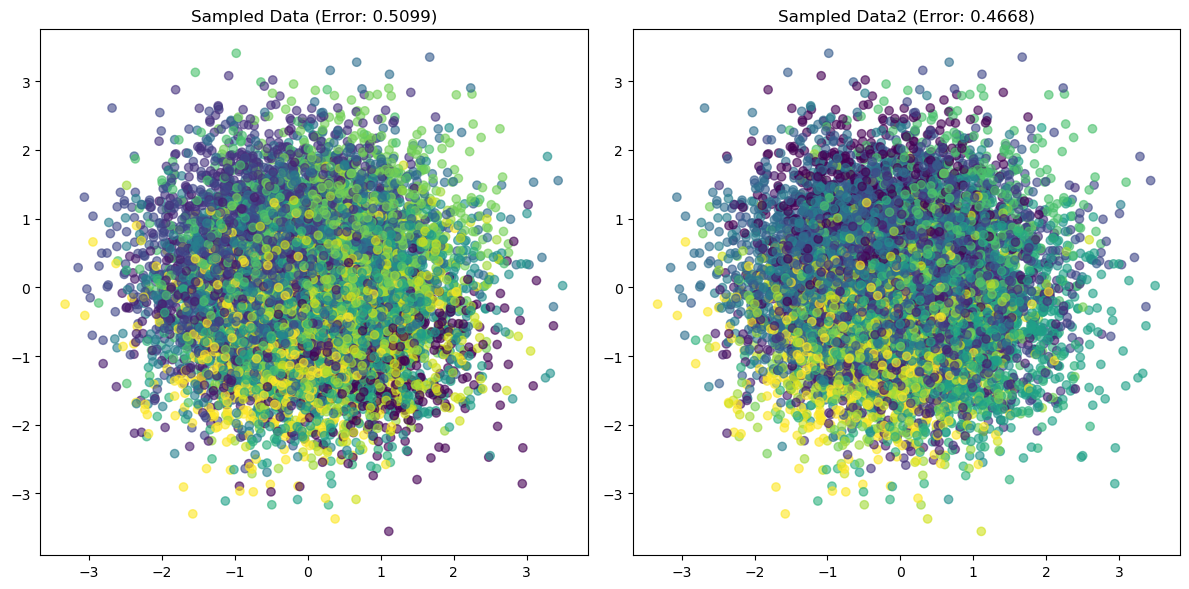

In [121]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.scatter(original_data['x1'], original_data['x2'], c=kmeans2.predict(original_data.drop('y', axis=1)), cmap='viridis', alpha=0.6)
plt.title(f"Sampled Data (Error: {error2:.4f})")


plt.subplot(122)
plt.scatter(original_data['x1'], original_data['x2'], c=kmeans3.predict(original_data.drop('y', axis=1)), cmap='viridis', alpha=0.6)
plt.title(f"Sampled Data2 (Error: {error3:.4f})")

plt.tight_layout()
plt.show()

In [126]:
con.stop_spark()

time: 2025-05-25 17:57:00.790160
del
stop
